# Introducción
El siguiente es un ejemplo de comparación entre la ejecución secuencial y la ejecución en paralelo. La aplicación tiene una funcionalidad sencilla, dada una imagen cuadrada (URL en Armado del ambiente) y un parámetro rotación, se obtiene una imagen resultado girada una determinada cantidad de grados.

Se presenta una primera implementación secuencial del algoritmo y una segunda trabajando en paralelo con hilos de CUDA.

# Armado del ambiente
Armado del ambiente

In [ ]:
#@title ## 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://image.freepik.com/vector-gratis/objeto-baloncesto-realista-sobre-fondo-blanco_33869-46.jpg" #@param {type:"string"}

# TODO: Mejorar información y resultado de ejecución. 
!wget {url_imagen} -O imagen.jpg

# Desarrollo
Ejecución de código en CPU.

626 626
Tiempo CPU:  1033.497 [ms]


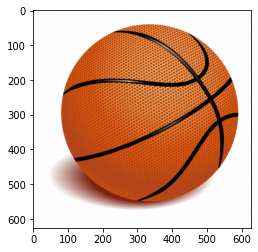

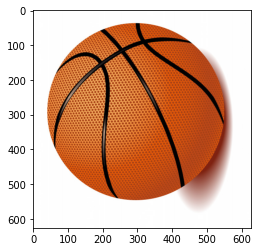

In [61]:
 #@title ## 3.1 Parámetros de ejecución
#@markdown ### Seleccione el ángulo al que se rotará la imagen (en sentido horario)

rotacion = 270 #@param {type:"slider", min:0, max:360, step:90}
 
 %matplotlib inline
from datetime import datetime

tiempo_total = datetime.now()

import  matplotlib.pyplot as plt
import numpy
from PIL import Image

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open(img_nombre)
  
img_w, img_h = image.size
print(img_w, img_h)

pxl_array = numpy.asarray(image)

img_picR_cpu = numpy.empty_like(pxl_array)

plt.figure()
imgplot = plt.imshow(pxl_array)

tiempo_cpu = datetime.now()

for y  in range(0, img_h):
  for x in range(0, img_w):
    r, g, b = pxl_array[y][x]

    if rotacion == 0 or rotacion == 360:
      img_picR_cpu[y][x] = [r, g, b]
    
    if rotacion == 90:
      img_picR_cpu[x][-y] = [r, g, b]
    
    if rotacion == 180:
      img_picR_cpu[-y][-x] = [r, g, b]
    
    if rotacion == 270:
      img_picR_cpu[-x][y] = [r, g, b]

tiempo_cpu = datetime.now() - tiempo_cpu

plt.figure()
imgplot = plt.imshow(img_picR_cpu)

print("Tiempo CPU: ", tiempo_en_ms(tiempo_cpu), "[ms]" )

Ejecución de código en GPU usando CUDA.

In [ ]:
#@title ## 3.2 Instalación de driver de CUDA para python
!pip install pycuda

Tiempo GPU:  0.301 [ms]


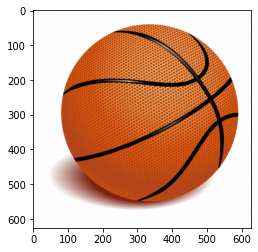

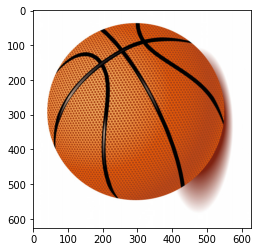

In [58]:
 #@title ## 3.3 Parámetros de ejecución
#@markdown ### Seleccione el ángulo al que se rotará la imagen (en sentido horario)

rotacion = 270 #@param {type:"slider", min:0, max:360, step:90}

%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open(img_nombre) 

img_w, img_h = image.size

pxl_array_original = numpy.asarray(image)
pxl_array_result = numpy.empty_like(pxl_array_original)

pxl_array_original_gpu = cuda.mem_alloc(pxl_array_original.nbytes)
pxl_array_result_gpu = cuda.mem_alloc(pxl_array_result.nbytes)

cuda.memcpy_htod(pxl_array_original_gpu, pxl_array_original)
cuda.memcpy_htod(pxl_array_result_gpu, pxl_array_result)

module = SourceModule("""
__global__ void kernel_img(int ancho, int alto, char *img_O, char *img_R, int rotacion)
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x * blockDim.x;
  int idy = threadIdx.y + blockIdx.y * blockDim.y;

  if(idx < ancho && idy < alto)
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    float r = (float) img_O[((idx * ancho + idy) * 3)];
    float g = (float) img_O[((idx * ancho + idy) * 3) + 1];
    float b = (float) img_O[((idx * ancho + idy) * 3) + 2];

    switch(rotacion)
    {
      case 0:
        img_R[(idx * ancho + idy) * 3  ] = r;
        img_R[(idx * ancho + idy) * 3 + 1] = g;
        img_R[(idx * ancho + idy) * 3 + 2] = b;
        break;
      case 90:
        img_R[(idy * ancho - idx) * 3  ] = r;
        img_R[(idy * ancho - idx) * 3 + 1] = g;
        img_R[(idy * ancho - idx) * 3 + 2] = b;
        break;
      case 180:
        img_R[((ancho - idx) * ancho - idy) * 3  ] = r;
        img_R[((ancho - idx) * ancho - idy) * 3 + 1] = g;
        img_R[((ancho - idx) * ancho - idy) * 3 + 2] = b;
        break;
      case 270:
        img_R[((ancho - idy) * ancho + idx) * 3  ] = r;
        img_R[((ancho - idy) * ancho + idx) * 3 + 1] = g;
        img_R[((ancho - idy) * ancho + idx) * 3 + 2] = b;
        break;
      case 360:
        img_R[(idx * ancho + idy) * 3  ] = r;
        img_R[(idx * ancho + idy) * 3 + 1] = g;
        img_R[(idx * ancho + idy) * 3 + 2] = b;
        break;
      default:
        img_R[(idx * ancho + idy) * 3  ] = r;
        img_R[(idx * ancho + idy) * 3 + 1] = g;
        img_R[(idx * ancho + idy) * 3 + 2] = b;
        break;
    }
  }
}
""") 

# CPU - Genero la función kernel.
kernel_img = module.get_function("kernel_img")

dim_hilo_x = 16
dim_bloque_x = numpy.int((img_w + dim_hilo_x - 1) / dim_hilo_x)

dim_hilo_y = 19
dim_bloque_y = numpy.int((img_h + dim_hilo_y - 1) / dim_hilo_y)

tiempo_img_gpu = datetime.now()

kernel_img(numpy.int32(img_w), numpy.int32(img_h), pxl_array_original_gpu, pxl_array_result_gpu, numpy.int32(rotacion), block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img_gpu = datetime.now() - tiempo_img_gpu

cuda.memcpy_dtoh(pxl_array_result, pxl_array_result_gpu)

plt.figure()
imgplot = plt.imshow(pxl_array_original)

plt.figure()
imgplot = plt.imshow(pxl_array_result)

print("Tiempo GPU: ", tiempo_en_ms(tiempo_img_gpu), "[ms]" )

# Tabla de pasos

Pasos comunes

 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  wget url_imagen       | Lectura de la dirección URL de la imagen (jpg) a procesar.

Pasos trabajando con CPU

 Procesador | Función | Detalle
------------|---------|----------
CPU      |  import                | Importación de módulos.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado. 
CPU      |  print()               | Informa los atributos de la imagen.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  for...for..           | Recorre cada pixel y lo guarda en su nueva posición dependiendo del parámetro de rotación.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra la imagen resultado.
CPU      |  print()               | Informa el tiempo de procesamiento.

Pasos trabajando con GPU

 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  matplotlib inline    | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importación de módulos.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado. 
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para las imagenes en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio el RAW de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el código del kernel.
CPU      |  module.get_function() | Convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel_img()          | Ejecuta la función antes definida en GPU, enviando los parametros.
CPU      | cuda.memcpy_dtoh()     | Copia desde la memoria GPU al CPU.
CPU      |  plt.imshow()          | Muestra la imagen original.
CPU      |  plt.imshow()          | Muestra la imagen resultado.
CPU      |  print()               | Informa el tiempo de procesamiento.

# Conclusiones

Ejecutadas las dos implementaciones, se puede percibir una enorme mejora de rendimiento del segundo algoritmo. La misma llega a superar al primero a veces hasta en una relación de 3000 a 1, en cuanto a tiempo se refiere.



In [63]:
print("Relación entre los tiempos de ejecución secuencial y paralela: \n", tiempo_cpu /tiempo_img_gpu)

Relación entre los tiempos de ejecución secuencial y paralela: 
 3433.5448504983387


Esto ocurre porque los hilos de CUDA trabajan de una forma muy distinta. Para empezar, lejos de recorrer cada pixel del formato RAW de la imagen, cada hilo trabaja con un único pixel. Los hilos CUDA desde su implementación están pensados para trabajar sobre este tipo de aplicaciones, es por esto que la diferencia entre uno y otro es tan enorme.

El ejercicio puede mejorarse añadiendo un parámetro para definir el sentido de rotación. También podría modificarse para que funcione con imágenes que no tienen el mismo alto que ancho.

# Bibliografía
Interactive Forms

https://colab.research.google.com/notebooks/forms.ipynb

An even easier introduction to CUDA

https://developer.nvidia.com/blog/even-easier-introduction-cuda/